## Amin Asadi 810196410
## Problems 9, 10, 11
##### Dataset: The provided TinyMNIST dataset in the "Data" folder(imported with the provided code)

### Problem 9
#### Used Libraries:
    - pandas, numpy
    - sklearn GaussianNB for implementing the classifier
    - matplotlib for plotting

#### Goal:
    - Implementing Sequential Forward Selection(SFS)

#### Description:
 High number of features in a dataset may lead to 'curse of dimmensionality'; Forward Selection is a method for finding a suitable smaller subset of features(dimmensions) of data so that we will have a more efficent model and avoid the mentioned problem.

#### Algorithm:
First we find the single feature that when chosen, leads to the best performance. Then from the remaining features we find the next feature that, with the first chosen feature they lead to the best performance. We continue this untill the accuracy does not increase.

In [3]:
import pandas as pd
import numpy as np

from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import VarianceThreshold
import matplotlib.pyplot as plt

### Importing Data:

In [4]:
# Loading Dataset
train_data = np.loadtxt('Data/TinyMNIST/trainData.csv', dtype=np.float32, delimiter=',')
train_labels = np.loadtxt('Data/TinyMNIST/trainLabels.csv', dtype=np.int32, delimiter=',')
test_data = np.loadtxt('Data/TinyMNIST/testData.csv', dtype=np.float32, delimiter=',')
test_labels = np.loadtxt('Data/TinyMNIST/testLabels.csv', dtype=np.int32, delimiter=',')
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

# Feature Selection
tr_samples_size, _ = train_data.shape
all_data = np.vstack((train_data,test_data))
sel = VarianceThreshold(threshold=0.90*(1-0.90))
all_data = sel.fit_transform(all_data)
train_data = all_data[:tr_samples_size]
test_data = all_data[tr_samples_size:]

tr_samples_size, feature_size = train_data.shape
te_samples_size, _ = test_data.shape
print('Train Data Samples:',tr_samples_size,
      ', Test Data Samples',te_samples_size,
      ', Feature Size(after feature-selection):', feature_size)

Train Data Samples: 5000 , Test Data Samples 2500 , Feature Size(after feature-selection): 62


In [5]:
X_train = train_data.copy()
X_test = test_data.copy()
y_train = train_labels.copy()
y_test = test_labels.copy()

### SFS function implementation:

In [6]:
def sfs():
    fixed_set = []
    step_accs = []
    remaining_features = list(range(feature_size))
    nbc = GaussianNB()

    for _ in range(feature_size):

        best_acc = -np.inf
        best_feature = None
        for f in remaining_features:
            
            fixed_set.append(f)
            sub_data = X_train[:, fixed_set].reshape(tr_samples_size, len(fixed_set))
            sub_target =  y_train.reshape(tr_samples_size, 1)
            nbc.fit(sub_data, sub_target)
            fixed_set.remove(f)

            score = nbc.score(sub_data, sub_target)
            if  score > best_acc:
                best_feature = f
                best_acc = score
        step_accs.append(best_acc)
        fixed_set.append(best_feature)
        remaining_features.remove(best_feature)

    return(step_accs)

step_accs = sfs()

### A) Plotting the result:

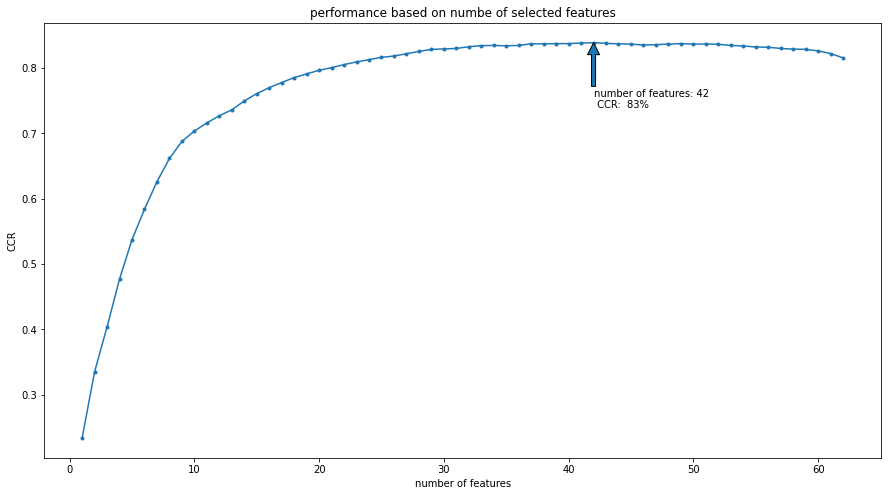

In [7]:
fig, ax = plt.subplots(figsize=(15,8))
x = np.arange(1, feature_size+1)
y = step_accs
y_max_idx = np.argmax(y)
x_max = x[y_max_idx]
y_max = np.max(y)
plt.plot(x, y, '.-');
plt.annotate('number of features: {} \n CCR:  {}%'.format(x_max, int(y_max*100)), (x_max, y_max), xytext=(x_max, y_max-0.1), arrowprops=dict())
plt.xlabel('number of features')
plt.ylabel('CCR')
plt.title('performance based on numbe of selected features');

### Result:
### B) As we can see from the above plot, the best number of features is: 42

# Problem 10

### Calculating Within-Class Scatter:

In [25]:
# calculating within-class scatter matrix:
s_w = np.zeros((X_train.shape[1], X_train.shape[1]))

for i in range(len(class_names)):
    class_data = X_train[np.where(y_train==i)]
    class_mean = np.mean(class_data, axis=0)
    class_scatter = np.dot((class_data - class_mean).T, class_data - class_mean)
    s_w = s_w + class_scatter

### Calculating Between-Class Scatter:

In [26]:
total_mean = np.mean(X_train, axis=0)

s_b = np.zeros((X_train.shape[1], X_train.shape[1]))

for i in range(len(class_names)):
    class_data = X_train[np.where(y_train==i)]
    n_i = class_data.shape[0]
    class_mean = np.mean(class_data, axis=0)
    mean_diff = n_i * np.dot((class_mean - total_mean).T, class_mean - total_mean)
    s_b = s_b + mean_diff

In [27]:
def inv(M):
    return np.linalg.inv(M)
     
def eig(M):
    return np.linalg.eig(M)

In [32]:
eig_vals, eig_vecs = eig(inv(s_w).dot(s_b))

In [33]:
eigval_eigvec = np.array(list(zip(np.abs(eig_vals), eig_vecs)))

In [34]:
decreasing_sorted = np.array(sorted(eigval_eigvec, key=lambda k : k[0], reverse=True))

In [37]:
decreasing_sorted[0][0]

285.43007071623794

In [ ]:
vals = decreasing_sorted[:,0]
fig,_ = plt.subplots(figsize=(10,6))
plt.plot(vals)
plt.title('Decreasing eigen values')
plt.xlabel('index of eigen value')
plt.ylabel('value');

In [ ]:
projection_matrix = inv(s_w).dot(s_b)

In [ ]:
new_num_of_features = 2

In [ ]:
W = np.hstack((eigval_eigvec[0][1].reshape(-1,1), eigval_eigvec[1][1].reshape(-1,1)))

In [ ]:
X_lda = X_train.dot(W)
X_lda.shape

In [ ]:
# fig, ax = plt.subplots()
# for i in range(len(class_names)):
#     class_data = X_train[np.where(y_train==i)]
#     ax.scatter(class_data)

ax = plt.subplots(figsize=(20,8))
for label in range(2):
    plt.scatter(x=X_lda[:,0].real[y_train == label],
            y=X_lda[:,1].real[y_train == label],
            # marker=marker,
            # color=color,
            alpha=0.5,
            # label=label_dict[label]
            )

In [ ]:
nbc = GaussianNB()
nbc.fit(X_lda.real, y_train)

In [ ]:
nbc.score(X_lda.real, y_train)

# Problem 11


#### Goal:
    - Implementing Principal Component Analysis(PCA)

#### Description:
 As mentioned in problem 10, high number of features in a dataset may lead to 'curse of dimmensionality'; PCA is a usefull method for descreasing number of dimmensions.

#### Algorithm:
- First we split the data to train and test data.
- Then we normalize the train and then normalize test data with the mean and std of train data. Normalization is necessary because we will use it as a fact in the formulas.
- Then we find the covariance matrix of train data.
- Then we find the eigen values and eigen vectors of the obtained ovariance matrix.
- After that we sort the the eigen values in descreasing order. Then we find the first d biggest eigen values which cover 90 percent of the data variance and then construct a transformation matrix based on the d corresponding eigen vectors.
- After that we stack the d obtained eigen vectors to form the transformation matrix.
- Then we transform the train and test data with that transformation matrix.

In [9]:
from sklearn.preprocessing import StandardScaler

def inv(M):
    return np.linalg.inv(M)
     
def eig(M):
    return np.linalg.eig(M)

In [57]:
X_train = train_data.copy()
X_test = test_data.copy()
y_train = train_labels.copy()
y_test = test_labels.copy()

### Step 1: NORMALIZATION:

In [58]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Step 2: COVARIANCE MATRIX COMPUTATION

In [59]:
cov = np.cov(X_train.T, ddof=0)

### 

### 11-A) STEP 3: EIGENVECTORS AND EIGENVALUES

In [60]:
eig_vals, eig_vecs = eig(cov)

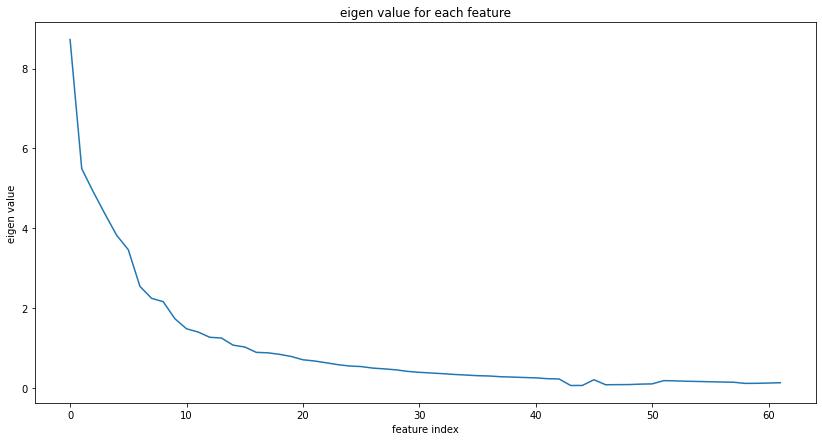

In [66]:
plt.figure(figsize=(14,7))
plt.plot(eig_vals);
plt.xlabel('feature index');
plt.ylabel('eigen value');
plt.title('eigen value for each feature');

### STEP 4: Finding principal features


In [67]:
eig_idx = np.arange(len(eig_vals))
sorted_eig = sorted(list(zip(eig_vals, eig_vecs, eig_idx)), reverse=True)

In [68]:
y = np.array([])
cumulative_sum = 0
for pair in sorted_eig:
    cumulative_sum += pair[0]
    y = np.append(y, cumulative_sum)
y = y*100 / y[-1]

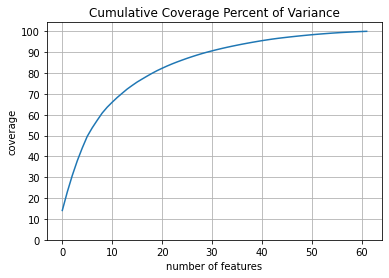

In [74]:
plt.plot(y)
plt.grid()
plt.yticks(np.arange(0,110,10))
plt.xlabel('number of features')
plt.ylabel('coverage')
plt.title('Cumulative Coverage Percent of Variance');

#### 11-B) We can see that about 30 features is enough to cover 90% of data variance

In [69]:
VARIANCE_BOUND = 90
idx = np.where(y >= VARIANCE_BOUND)[0][0]

number_of_principal_features = idx + 1
number_of_principal_features

31

In [76]:
print('Least number of feature for covering 90% variance of the data =', number_of_principal_features)

Least number of feature for covering 90% variance of the data = 31


### 11-C) STEP 5: DATA TRANSFORMATION ALONG THE PRINCIPAL COMPONENTS AXES

In [41]:
principal_eigvecs = [pair[1] for pair in sorted_eig[:number_of_principal_features]]
transformation_matrix = np.stack(principal_eigvecs)

In [53]:
transformed_X_train = transformation_matrix.dot(X_train.T).T
transformed_X_test = transformation_matrix.dot(X_test.T).T

### Performance before performing PCA:

In [82]:
nbc = GaussianNB()
nbc.fit(X_train, y_train)
print('CCR before performing PCA  = {}%'.format(nbc.score(X_test, y_test) * 100))

CCR before performing PCA  = 76.48%


### Performance after performing PCA:

In [83]:
nbc = GaussianNB()
nbc.fit(transformed_X_train, y_train)
print('CCR after performing PCA = {}%'.format(nbc.score(transformed_X_test, y_test) * 100))

CCR after performing PCA = 73.52%


### Result:
 We seee the althogh we used only half of the features the performance is nearly the same as before. So PCA has helped us to decrease the dimmension by half while having the same performance.